In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/finish'
ruta_archivo = os.path.join(ruta, 'pop_last.csv')
new_df = pd.read_csv(ruta_archivo)

# Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tf = vectorizer.fit_transform(new_df['lyrics'])
feature_names = vectorizer.get_feature_names_out()

# Promedio de TF-IDF por clase
pop_tfidf = X_tf[new_df['tag'] == 'pop'].mean(axis=0).A1 # .A1 converts the resulting matrix into a flattened one-dimensional NumPy array.
other_tfidf = X_tf[new_df['tag'] != 'pop'].mean(axis=0).A1

# Diferencia de importancia
tfidf_diff = pop_tfidf - other_tfidf
relevant_features = sorted(zip(tfidf_diff, feature_names), reverse=True)

print("Palabras o n-gramas más relevantes para 'pop':")
for diff, feature in relevant_features[:10]:
    print(f"{feature}: {diff}")

tfidf_df = pd.DataFrame(X_tf.toarray(), columns=vectorizer.get_feature_names_out())

# Prepare the data for training
X = tfidf_df
y = new_df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mounted at /content/drive
Palabras o n-gramas más relevantes para 'pop':
youre: 0.006563081236117464
love: 0.006121025994000662
oh: 0.004458935012349313
away: 0.004189336760170808
ill: 0.003653875143654884
chorus: 0.0035769270765021533
theres: 0.003310538297288031
oh oh: 0.0031705015467926017
feel: 0.003155921023132391
heart: 0.0031135683037321754


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

     non-pop       0.64      0.65      0.64      1981
         pop       0.65      0.64      0.64      2019

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels to numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

input_dim = X_train.shape[1]

clf2 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Salida binaria (pop o no pop)
])
clf2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use encoded labels for training
clf2.fit(np.array(X_train), np.array(y_train_encoded), epochs=10, batch_size=32, validation_split=0.2)

# Predict and evaluate using encoded labels
y_pred2 = (clf2.predict(np.array(X_test)) > 0.5).astype("int32")
y_pred2_labels = label_encoder.inverse_transform(y_pred2.flatten())
print("\nClassification Report:\n", classification_report(y_test, y_pred2_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6082 - loss: 0.6513 - val_accuracy: 0.6550 - val_loss: 0.6070
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7409 - loss: 0.5280 - val_accuracy: 0.6419 - val_loss: 0.6319
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8076 - loss: 0.4256 - val_accuracy: 0.6325 - val_loss: 0.7110
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8949 - loss: 0.2747 - val_accuracy: 0.6116 - val_loss: 0.8940
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9556 - loss: 0.1384 - val_accuracy: 0.6112 - val_loss: 1.2133
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9843 - loss: 0.0595 - val_accuracy: 0.6047 - val_loss: 1.4500
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9931 - loss: 0.0300 - val_accuracy: 0.6078 - val_loss: 1.6991
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9946 - loss: 0.0209 - val_accurac

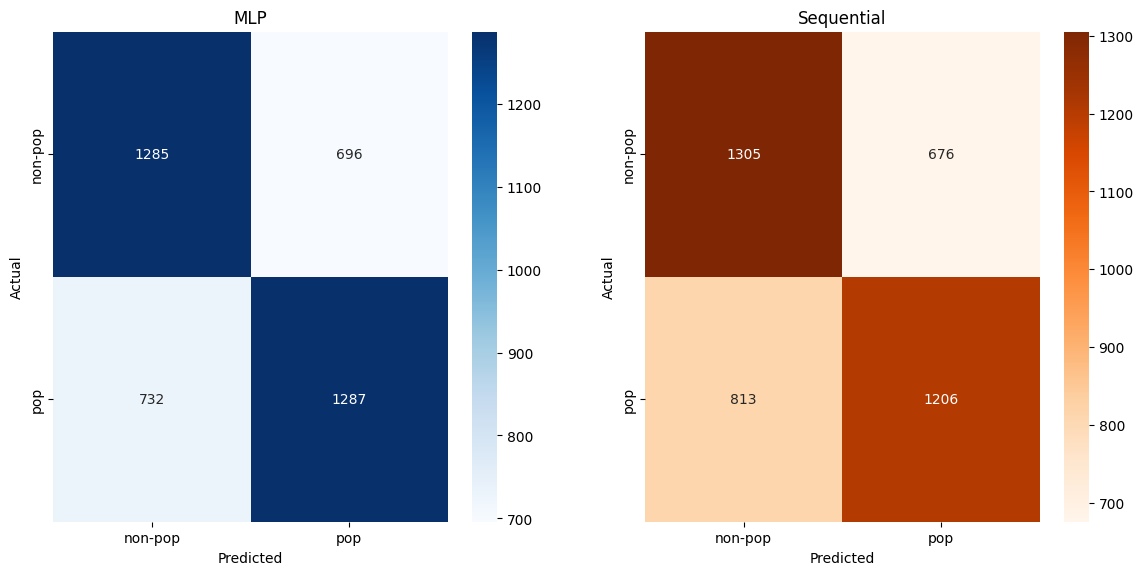

In [ ]:
# Assuming y_test and y_pred are already defined from the previous code
CLASSES = sorted(new_df['tag'].unique())
cm = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred2_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(14, 14))

plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP")

plt.subplot(2, 2, 2)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Sequential")
plt.show()